In [1]:

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as  pd
import numpy as np
import math
from tqdm import tqdm
sns.set_context("paper", rc={"axes.labelsize":40})
num_epochs=20
batch_size=64


In [2]:
tf.set_random_seed(781998)
class model():
    def __init__(self):
        with tf.Graph().as_default():
            self.x=tf.placeholder(tf.float32,shape=[None,784])
            self.labels=tf.placeholder(tf.int32,shape=[None])
            
            #network
            self.layer1=tf.layers.dense(self.x,1000,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer2=tf.layers.dense(self.layer1,1000,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer3=tf.layers.dense(self.layer2,500,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.layer4=tf.layers.dense(self.layer3,200,activation=tf.nn.relu,use_bias=False,kernel_initializer='glorot_uniform')
            self.logits=tf.layers.dense(self.layer4,10,use_bias=False,kernel_initializer='glorot_uniform')
            self.probs=tf.nn.softmax(self.logits,axis=1)
            
            
            self.loss=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.labels,logits=self.logits)
            self.loss=tf.reduce_mean(self.loss)
            
            self.trainable_vars=tf.trainable_variables()#holds trainable variables for pruning
            self.varstosparsify=self.trainable_vars[:-1]#no pruning for last layer
            self.last_layer=self.trainable_vars[-1]
            
            
            self.sparsified_weights=[]#to hold sparse tensors       
            self.pruned_weights=[]#to hold dense pruned weights
            
            self.opt=tf.train.AdamOptimizer().minimize(self.loss)
            self.saver=tf.train.Saver()
            self.graph=tf.get_default_graph()   
    def weightpruneeager(self,weight,percentile):  
        #this function is used for weight pruning
        weight_numpy=weight.numpy()
        val=np.percentile(np.abs(weight_numpy),percentile)
        mask=np.abs(weight_numpy)<val#get mask to be set to zero
        weight_numpy[mask]=0
        denseweight=tf.convert_to_tensor(weight_numpy)
        self.pruned_weights.append(denseweight)#add dense tensors
        self.sparsified_weights.append(tf.contrib.layers.dense_to_sparse(denseweight))#add sparsified tensors 
        return denseweight
    def unitpruneeager(self,weight,percentile):
        #this function is used for unit pruning
        weight_numpy=weight.numpy()
        col_norm = np.linalg.norm(weight_numpy, axis=0)#get l2 norm of each column
        val= np.percentile(col_norm, percentile)
        mask = col_norm < val#get mask
        weight_numpy[:,mask] = 0
        weight_numpy=tf.convert_to_tensor(weight_numpy)
        self.pruned_weights.append(weight_numpy)
        self.sparsified_weights.append(tf.contrib.layers.dense_to_sparse(weight_numpy))
        return weight_numpy
    def sparseevaluateeager(self,x):
        #evaluating the model using sparse matrix multiplications
        #no transpose is required as the transposed matrix is sent from feed_dict
        #the returned result is (10,batch_size)
        sparsed_weights=self.sparsified_weights
        a1=tf.nn.relu(tf.sparse.matmul(sparsed_weights[0],x,adjoint_a=True))
        a2=tf.nn.relu(tf.sparse.matmul(sparsed_weights[1],a1,adjoint_a=True))
        a3=tf.nn.relu(tf.sparse.matmul(sparsed_weights[2],a2,adjoint_a=True))
        a4=tf.nn.relu(tf.sparse.matmul(sparsed_weights[3],a3,adjoint_a=True))
        preds=tf.matmul(tf.convert_to_tensor(sparsed_weights[4]),a4)
        return preds
    def denseevaluateeager(self,x):
        #evaluating the model using pruned weights and normal matmul
        #the returned result is (batch_size,10)
        pruned_weights=self.pruned_weights
        a1=tf.nn.relu(tf.matmul(x,pruned_weights[0]))
        a2=tf.nn.relu(tf.matmul(a1,pruned_weights[1]))
        a3=tf.nn.relu(tf.matmul(a2,pruned_weights[2]))
        a4=tf.nn.relu(tf.matmul(a3,pruned_weights[3]))
        preds=tf.matmul(a4,tf.convert_to_tensor(pruned_weights[4]))
        return preds
    def getloss(self,probs,y):
        loss=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=probs)
        loss=tf.reduce_mean(loss)
        return loss
        

     



In [3]:
model=model()

In [4]:
#getting the dataset
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32).reshape((-1,1))
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32).reshape((-1,1))
print(train_labels.shape)

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 1)


In [5]:
#shuffle the dataset
train=np.concatenate((train_data,train_labels),axis=1)
eval=np.concatenate((eval_data,eval_labels),axis=1)
np.random.shuffle(train)
np.random.shuffle(eval)


In [6]:
#split dataset into batches
train_batches=np.array_split(train,math.ceil(train.shape[0]/batch_size),axis=0)
eval_batches=np.array_split(eval,math.ceil(eval.shape[0]/batch_size),axis=0)


In [7]:
#function to get number of correctly classified instances of the current batch
def checkequal(p,a,axis=1):
    p=np.argmax(p,axis=axis)
    if axis==0: p=p.T
    return np.sum(p==a)

In [8]:
import time
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.allow_growth = True
train_stats={}
train_stats['index']=[]
train_stats['train_loss']=[]
train_stats['test_acc']=[]
train_stats['train_acc']=[]
with tf.Session(config=tf.ConfigProto(log_device_placement=True),graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        train_stats['index'].append(i)
        
        ls=0
        train_correct=0
        train_total=0
        for batch in tqdm(train_batches):
            data,y=batch[:,:-1],batch[:,-1]
            y=y.astype(np.int32)
            l,_,p=sess.run([model.loss,model.opt,model.probs],feed_dict={model.x:data,model.labels:y})
            train_correct+=checkequal(p,y)
            train_total+=y.shape[0]
            ls+=l
        
        ls=ls/len(train_batches)
        train_acc=float(train_correct)/float(train_total)
        train_stats['train_loss'].append(ls)
        train_stats['train_acc'].append(train_acc)
        
        test_correct=0
        test_total=0
        for batch in eval_batches:
            data,y=batch[:,:-1],batch[:,-1]
            p=sess.run(model.probs,feed_dict={model.x:data})
            test_correct+=checkequal(p,y)
            test_total+=y.shape[0]
        
        test_acc=float(test_correct)/float(test_total)
        train_stats['test_acc'].append(test_acc)
        print(str(i)+' loss:'+str(ls)+' train_acc:'+str(train_acc)+' test_acc:'+str(test_acc))
        #save model 
        model.saver.save(sess,'model/notpruned/model.pb')
train_df=pd.DataFrame(train_stats)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))
ax1=sns.pointplot(x='index',y='train_loss',data=train_df,ax=axs[0])
ax2=sns.pointplot(x='index',y='train_acc',data=train_df,ax=axs[1])
ax3=sns.pointplot(x='index',y='test_acc',data=train_df,ax=axs[2])

 37%|███▋      | 320/860 [00:01<00:07, 72.50it/s]


KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from model/notpruned/model.pb


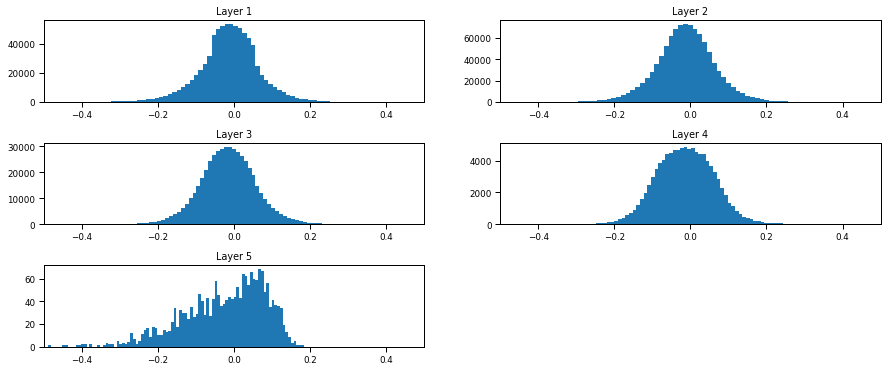

In [9]:
with tf.Session(config=config,graph=model.graph) as sess:
    model.saver.restore(sess,'model/notpruned/model.pb')
    plt.figure(1, figsize=(15,6))
    plt.subplots_adjust(hspace=0.5)
    for i, weights in enumerate(model.trainable_vars):
        plt.subplot(3,2,i+1)
        plt.title("Layer {}".format(i+1))
        plt.hist(sess.run(weights).reshape(-1), bins=100)
        plt.xlim(-0.5, 0.5);

In [10]:
k=[0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [11]:
tfe = tf.contrib.eager

In [12]:
def sparsedensecompare(eval_time_data,eval_data,p):
    #this function is used for evaluating the pruned weights on the test set.
    #both the pruned (zeroed out but dense) and sparsified weights are evaluated and the timings are compared 
    time_sparse=time.clock()
    with tf.Session(config=config,graph=model.graph) as sess:
            test_correct=0
            test_total=0
            x=tf.placeholder(tf.float32)
            #tfe.py_func() iWraps a python function into a TensorFlow op that executes it eagerly 
            sparseevaluate_func=tfe.py_func(model.sparseevaluateeager,[x],tf.float32)
            
            #evaluating on test set using sparsed weights
            for batch in eval_batches:
                data,y=batch[:,:-1],batch[:,-1]  
                preds_sparse=sess.run(sparseevaluate_func,feed_dict={x:data.T})
                test_correct+=checkequal(preds_sparse,y,axis=0)
                test_total+=y.shape[0]
                
                
    time_sparse=time.clock()-time_sparse
    test_acc_sparse=float(test_correct)/float(test_total)
    eval_time_data['time'].append(time_sparse)
    eval_time_data['category'].append('sparse')
    
    
    time_dense = time.clock()
    with tf.Session(config=config,graph=model.graph) as sess:       
            test_correct=0
            test_total=0
            x=tf.placeholder(tf.float32)
            denseevaluate_func=tfe.py_func(model.denseevaluateeager,[x],tf.float32)
            
            #evaluating on test set using dense weights (pruned)
            for batch in eval_batches:
                data,y=batch[:,:-1],batch[:,-1]
                preds_dense=sess.run(denseevaluate_func,feed_dict={x:data})
                test_correct+=checkequal(preds_dense,y,axis=1)
                test_total+=y.shape[0]
    
            
    time_dense = time.clock()-time_dense
    test_acc_dense=float(test_correct)/float(test_total)
    assert test_acc_dense==test_acc_sparse
    eval_data['acc'].append(test_acc_dense)
    eval_time_data['time'].append(time_dense)
    eval_time_data['category'].append('dense')
    
    with tf.Session(config=config,graph=model.graph) as sess:
        x=tf.placeholder(tf.float32)
        labels=tf.placeholder(tf.int32)
        logits=tf.placeholder(tf.float32)
        denseevaluate_func=tfe.py_func(model.denseevaluateeager,[x],tf.float32)
        loss_func=tfe.py_func(model.getloss,[logits,labels],tf.float32)
        #calculating loss for pruned weights on the test set
        test_ls=0
        for batch in eval_batches:
            data,y=batch[:,:-1],batch[:,-1]
            preds_dense=sess.run(denseevaluate_func,feed_dict={x:data})     
            ls=sess.run(loss_func,feed_dict={labels:y,logits:preds_dense})
            test_ls+=ls/len(eval_batches)
        eval_data['loss'].append(test_ls)
    print('k:'+str(p)+' test_acc:'+str(test_acc_dense)+' time_sparse:'+str(time_sparse)+ ' time_dense:'+str(time_dense)+' test_loss:'+str(test_ls))
    
    
    
    
    

# WEIGHT PRUNING

INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:0 test_acc:0.9822 time_sparse:1.0188990000000047 time_dense:0.9470759999999956 test_loss:0.08430799201491103
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:25 test_acc:0.9827 time_sparse:0.8682129999999972 time_dense:1.2920430000000067 test_loss:0.08257718672601207
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:50 test_acc:0.9823 time_sparse:0.7666889999999995 time_dense:1.3216850000000022 test_loss:0.07592092476720119
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:60 test_acc:0.982 time_sparse:0.7137390000000039 time_dense:1.2253009999999875 test_loss:0.07205904621051057
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:70 test_acc:0.9822 time_sparse:0.6852400000000074 time_dense:0.9787970000000001 test_loss:0.0740407842306338
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:80 test_acc:0.9795 time_sparse:0.525299

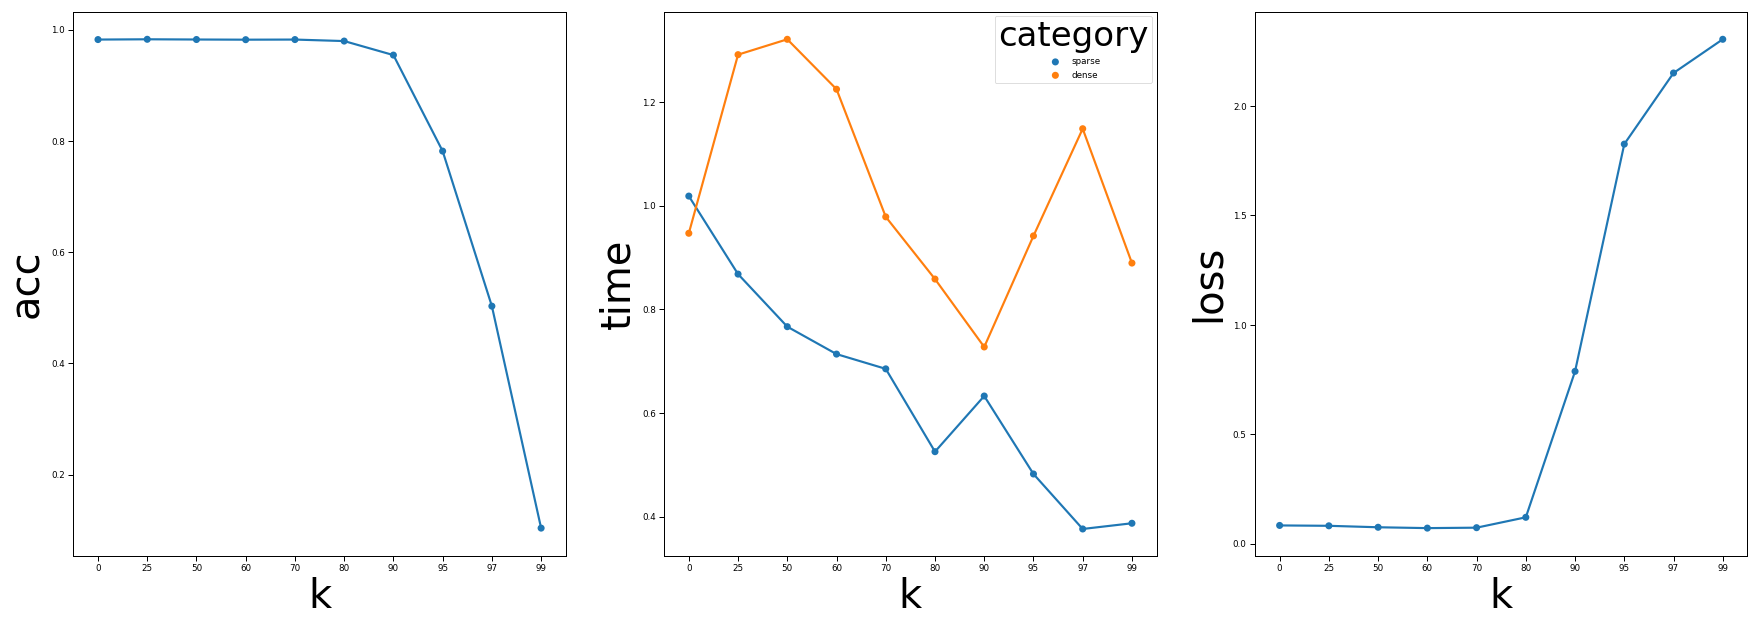

In [13]:
import time

#dictionaries used to store stats for evaluation such as time and accuracy.
eval_time_data={}
eval_time_data['k']=[]
eval_time_data['time']=[]
eval_time_data['category']=[]
eval_data={}
eval_data['k']=[]
eval_data['acc']=[]
eval_data['loss']=[]

for p in k:
    
    eval_data['k'].append(p)
    eval_time_data['k'].append(p)
    eval_time_data['k'].append(p)
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config,graph=model.graph) as sess:
        #retore the not pruned model
        model.saver.restore(sess,'model/notpruned/model.pb')
        model.sparsified_weights=[]
        model.pruned_weights=[]
        percentile=tf.placeholder(tf.float32)
        wt=tf.placeholder(tf.float32)
        
        #each weight is pruned using the weightpruneeager function defined in the model
        weight_prune_func=tfe.py_func(model.weightpruneeager,[wt,percentile],[tf.float32])
        for v in model.varstosparsify:
            w=sess.run(v)
            
            #get each weight to be pruned as numpy array and feed it into the eager function (weightpruneeager)  for pruning
            sp=sess.run(weight_prune_func,feed_dict={wt:w,percentile:p})
        #get last layer as is 
        last_layer=sess.run(model.last_layer)
        model.sparsified_weights.append(last_layer.T)
        model.pruned_weights.append(last_layer)
    
    sparsedensecompare(eval_time_data,eval_data,p)

eval_time_df=pd.DataFrame(eval_time_data)
eval_df=pd.DataFrame(eval_data)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))

ax1=sns.pointplot(x='k',y='acc',data=eval_df,ax=axs[0])
ax2=sns.pointplot(x='k',y='time',hue='category',data=eval_time_df,ax=axs[1])
ax3=sns.pointplot(x='k',y='loss',data=eval_df,ax=axs[2])

# unit pruning

INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:0 test_acc:0.9822 time_sparse:0.9179639999999978 time_dense:1.3896349999999984 test_loss:0.08430799201491103
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:25 test_acc:0.9823 time_sparse:0.8488900000000008 time_dense:0.8437790000000014 test_loss:0.0787219150328279
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:50 test_acc:0.9818 time_sparse:0.778105 time_dense:1.2721630000000026 test_loss:0.06876233227515394
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:60 test_acc:0.9798 time_sparse:0.695606999999999 time_dense:0.729025 test_loss:0.12207737580463765
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:70 test_acc:0.956 time_sparse:0.7292920000000009 time_dense:0.9678110000000011 test_loss:0.502034962556924
INFO:tensorflow:Restoring parameters from model/notpruned/model.pb
k:80 test_acc:0.8745 time_sparse:0.6668249999999958 time_dense:0

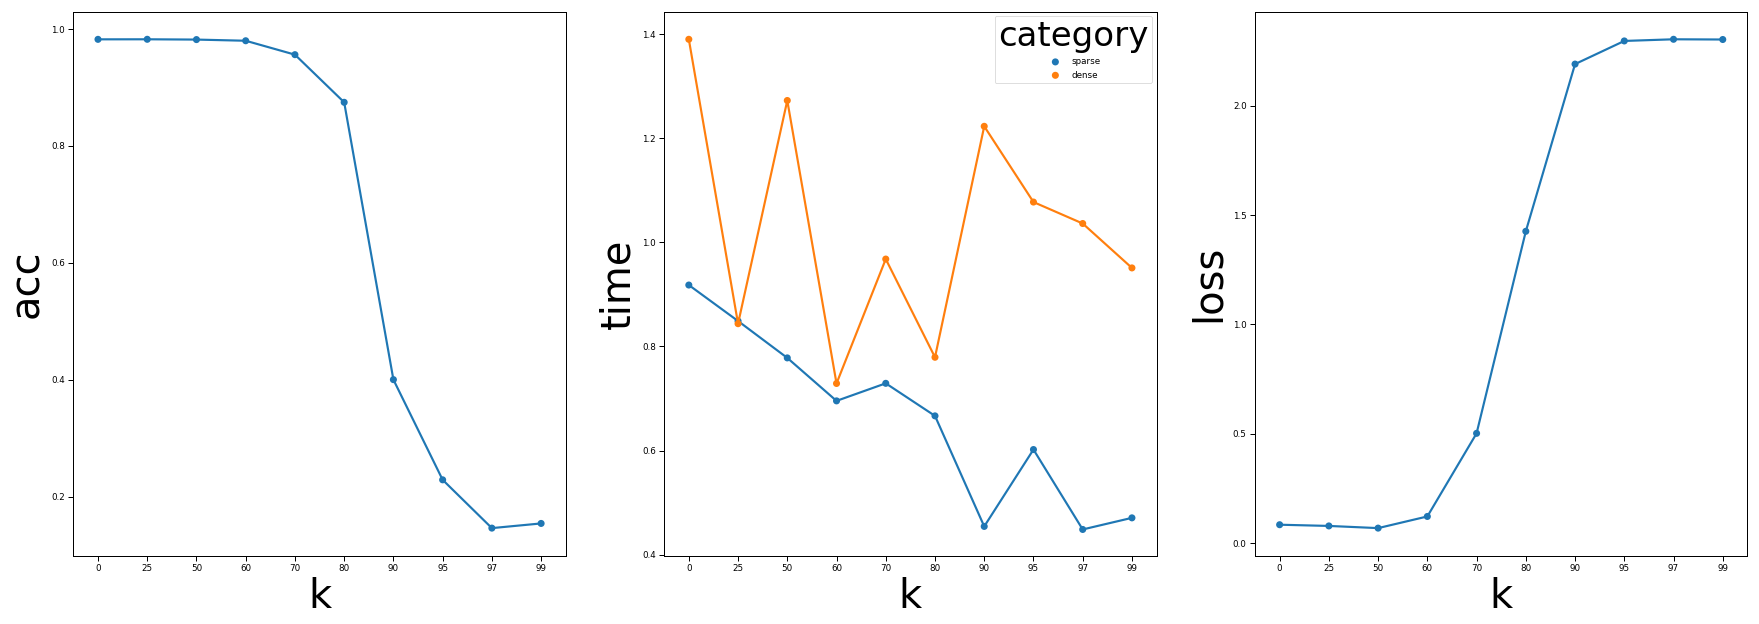

In [13]:
eval_time_data={}
eval_time_data['k']=[]
eval_time_data['time']=[]
eval_time_data['category']=[]
eval_data={}
eval_data['k']=[]
eval_data['acc']=[]
eval_data['loss']=[]
for p in k:
    eval_data['k'].append(p)
    eval_time_data['k'].append(p)
    eval_time_data['k'].append(p)
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config,graph=model.graph) as sess:
        model.saver.restore(sess,'model/notpruned/model.pb')
        model.sparsified_weights=[]
        model.pruned_weights=[]
        percentile=tf.placeholder(tf.float32)
        wt=tf.placeholder(tf.float32)
        unit_prune_func=tfe.py_func(model.unitpruneeager,[wt,percentile],[tf.float32])
        for v in model.varstosparsify:
            w=sess.run(v)
            sp=sess.run(unit_prune_func,feed_dict={wt:w,percentile:p})
        last_layer=sess.run(model.last_layer)
        model.sparsified_weights.append(last_layer.T)
        model.pruned_weights.append(last_layer)
    
    sparsedensecompare(eval_time_data,eval_data,p)
eval_time_df=pd.DataFrame(eval_time_data)
eval_df=pd.DataFrame(eval_data)
fig, axs = plt.subplots(ncols=3,figsize=(30,10))
ax1=sns.pointplot(x='k',y='acc',data=eval_df,ax=axs[0])
ax2=sns.pointplot(x='k',y='time',hue='category',data=eval_time_df,ax=axs[1])
ax3=sns.pointplot(x='k',y='loss',data=eval_df,ax=axs[2])